In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn

train = pd.read_csv('./data/train.csv', index_col='PassengerId')
test = pd.read_csv('./data/test.csv', index_col='PassengerId')

In [4]:
import pandasgui
# pandasgui.show(train)

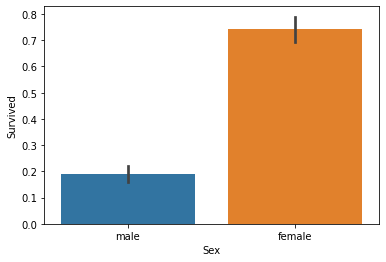

In [5]:
# Survived by sex

seaborn.barplot(
    x='Sex', y='Survived',
    data=train
)
plt.show()

In [6]:
print(sum(train['Sex'] == 'female'))
print(sum(train['Sex'] == 'male'))

314
577


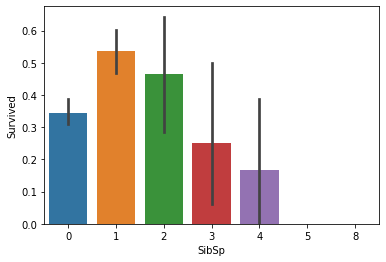

In [7]:
# Survived by SibSp

seaborn.barplot(
    x='SibSp', y='Survived',
    data=train
)
plt.show()

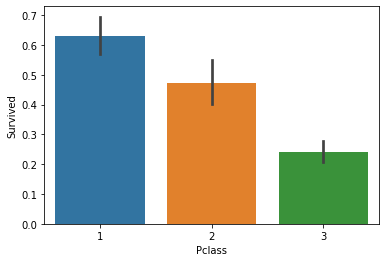

In [8]:
# Survived by Pclass

seaborn.barplot(
    x='Pclass', y='Survived',
    data=train
)
plt.show()


In [9]:
# Mr, Miss ...
counts = {}

for name in train['Name']:
    for word in name.split():
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 0

print(sorted(list(filter(lambda tup: tup[1] > 1, counts.items())), key=lambda tup: tup[1], reverse=True)[:10])

[('Mr.', 516), ('Miss.', 181), ('Mrs.', 124), ('William', 61), ('John', 43), ('Master.', 39), ('Henry', 32), ('James', 23), ('Charles', 22), ('George', 21)]


In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy

class ColumnAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_rank=True, add_age_group=True, add_is_alone=True):
        self.add_rank = add_rank
        self.add_is_alone = add_is_alone
        self.add_age_group = add_age_group

    @staticmethod
    def age_to_group(age):
        if age < 18:
            return '1'
        if age < 40:
            return '2'
        return '3'

    @staticmethod
    def name_to_rank(name):
        for rank in ['Mr.', 'Miss.', 'Mrs.', 'Master.']:
            if rank in name:
                return rank
        return 'Unranked'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = deepcopy(X)

        if self.add_rank:
            X['Rank'] = X['Name'].apply(ColumnAdder.name_to_rank)

        if self.add_age_group:
            X['AgeGroup'] = X['Age'].apply(ColumnAdder.age_to_group)

        if self.add_is_alone:
            X['IsAlone'] = (X['Parch'] + X['SibSp']) == 0

        return X


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)

X_train = ColumnAdder().fit_transform(X_train)
X_train.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

X_test = ColumnAdder().fit_transform(test)
X_test.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

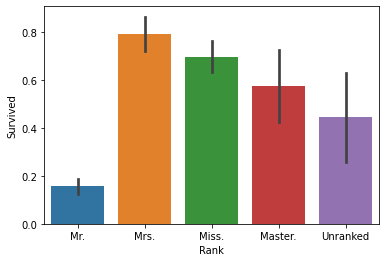

In [12]:
# Survived by Rank

seaborn.barplot(
    x=X_train['Rank'], y=y_train
)
plt.show()

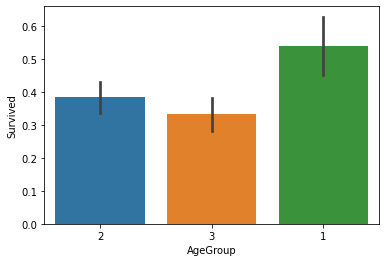

In [13]:
# Survived by AgeGroup

seaborn.barplot(
    x=X_train['AgeGroup'], y=y_train
)
plt.show()

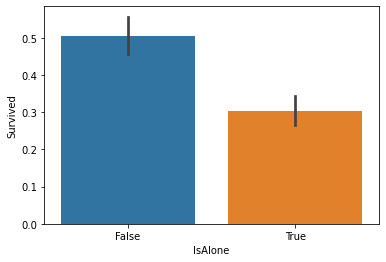

In [14]:
# Survived by IsAlone

seaborn.barplot(
    x=X_train['IsAlone'], y=y_train
)
plt.show()

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_columns = X_train.columns[X_train.dtypes == 'object']

num_columns = [
    col
    for col in X_train.columns
    if col not in cat_columns
]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_columns)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_columns)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [16]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [17]:
kaggle_lib = __import__('kaggle_lib')
Submitter = kaggle_lib.Submitter
search_params = kaggle_lib.search_params

submitter = Submitter(compete='titanic', work_dir='C:/Users/uiqko/GoogleDrive/code/multilang/kaggle-titanic/Submissions')

submit_args = {
    'save_model': True,
    'open_in_browser': False,
}

def create_predicted_df(predicted, index):
    return pd.DataFrame(dict(zip(['PassengerId', 'Survived'], [index, predicted])))


### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

best_estimator = search_params(
    RandomForestClassifier(),
    X_train_prepared, y_train, random=False,
    param_grid=[
        {'n_estimators': [3, 10, 30, 70, 100, 150], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
    ]
).best_estimator_

Time: 20.51008629798889 sec
Best estimator: RandomForestClassifier(max_features=8, n_estimators=10)


In [19]:
submitter.submit(
    predicted=create_predicted_df(best_estimator.predict(X_test_prepared), X_test.index),
    submission_name=str(best_estimator),
    model=best_estimator,
    **submit_args
)

Uploading submission...
kaggle competitions submit -c titanic -f "C:/Users/uiqko/GoogleDrive/code/multilang/kaggle-titanic/Submissions/0  --  RandomForestClassifier(max_features=8, n_estimators=10)/submission.csv" -m "RandomForestClassifier(max_features=8, n_estimators=10)"
Output:  0


In [20]:
submitter.check_submission()

Date:  2020-11-23T12:58:40.263Z
Status:  complete
Score:  0.76315


### XGBoost

In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train_prepared, y_train)

submitter.submit(
    predicted=create_predicted_df(xgb.predict(X_test_prepared), X_test.index),
    model=xgb,
    model_name='XGBClassifier()',
    submission_name='xgb with default params',
    **submit_args
)

Uploading submission...
kaggle competitions submit -c titanic -f "C:/Users/uiqko/GoogleDrive/code/multilang/kaggle-titanic/Submissions/1  --  xgb with default params/submission.csv" -m "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)"
Output:  0


In [22]:
submitter.check_submission()

Date:  2020-11-23T12:59:31.563Z
Status:  complete
Score:  0.73444


In [23]:
xgb_search = search_params(
    XGBClassifier(),
    X_train_prepared, y_train, random=False,
    param_grid = {
        'n_estimators': [50, 100, 150, 200, 500],
        'learning_rate': [1, 0.5, 0.1, 0.05],
        'n_jobs': [1, 2, 4]
    }
).best_estimator_

Time: 25.442548274993896 sec
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [24]:
submitter.submit(
    predicted=create_predicted_df(xgb_search.predict(X_test_prepared), X_test.index),
    model=xgb_search,
    model_name='XGBClassifier(searched_params)',
    submission_name='xgb with searched params',
    **submit_args
)

Uploading submission...
kaggle competitions submit -c titanic -f "C:/Users/uiqko/GoogleDrive/code/multilang/kaggle-titanic/Submissions/2  --  xgb with searched params/submission.csv" -m "XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)"
Output:  0


In [ ]:
submitter.check_submission()

In [25]:
submitter.check_submission()

Date:  2020-11-23T13:00:27.963Z
Status:  complete
Score:  0.76315
